# 自己回帰移動平均モデル（ARMAモデル）

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

## 訓練データ生成

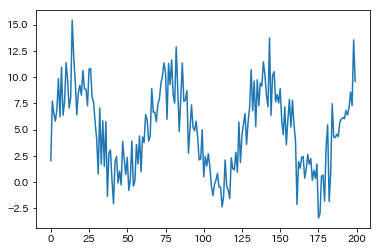

In [2]:
xx = np.arange(200)
xx = 5 * np.sin(0.1 * xx) + 2 * np.random.normal(size=200) + 5.
plt.plot(xx)

## 学習

時系列データが$X=[x_{1}, x_{2}, .., x_{n}]$のとき、ARMAモデルはARモデルとMAモデルを組み合わせた、つまり$x_{s} = w_{0}+ \sum_{j=1}^{m} w_{j} x_{s-j} + \sum_{j=1}^{m'} \theta_{j} \epsilon_{s-j} + \epsilon_{s}$で与えられる。

ただし、$w_{j}, \theta_{j}$は重みパラメータ、$\epsilon_{s}$は時刻$s$でのノイズであり平均$0$、分散$\sigma^{2}$の正規分布に従うものと仮定する。

このとき$p(x_{s}|x_{s-1}, x_{s-2}, .., x_{s-m}; \boldsymbol{w}, \boldsymbol{\theta}, \sigma^{2}) = \mathcal{N}(x_{s} | w_{0}+ \sum_{j=1}^{m} w_{j} x_{s-j} + \sum_{j=1}^{m'} \theta_{j} \epsilon_{s-j}, \sigma^{2})$とかける。パラメータを最尤推定により求める。対数尤度関数は、

\begin{eqnarray}
\log{p(X | \boldsymbol{w}, \boldsymbol{\theta}, \sigma^{2})} &=& \prod_{s=1}^{n} p(x_{s} | x_{s-1}, x_{s-2}, .., x_{s-m}, \epsilon_{s-1}, \epsilon_{s-2}, .., \epsilon_{s-m};\boldsymbol{w}, \boldsymbol{\theta}, \sigma^{2}) \\
&=& \sum_{s=1}^{n} [-\frac{1}{2}\log{2 \pi} - \log{\sigma} - \frac{1}{2 \sigma^{2}}(x_{s} - w_{0} - \sum_{j=1}^{m} w_{j} x_{s-j} - \sum_{j=1}^{m'} \theta_{j} \epsilon_{s-j})^{2}] \\
&=& \sum_{s=1}^{n} [-\frac{1}{2}\log{2 \pi} - \frac{1}{2}\log{\sigma^{2}} - \frac{\epsilon_{s}^{2}}{2 \sigma^{2}} ]
\end{eqnarray}

となり、ただし、$x_{i}=0, \epsilon_{i}=0 (i \le 0)$とする。各パラメータで偏微分すると、

\begin{eqnarray}
\frac{\partial}{\partial w_{0}} (\log{p(X | \boldsymbol{w}, \boldsymbol{\theta}, \sigma^{2})}) &=& \frac{1}{\sigma^{2}} \sum_{s=1}^{n} (x_{s} - w_{0} - \sum_{j=1}^{m} w_{j} x_{s-j} - \sum_{j=1}^{m'} \theta_{j} \epsilon_{s-j}) \\
\frac{\partial}{\partial w_{i}} (\log{p(X | \boldsymbol{w}, \boldsymbol{\theta}, \sigma^{2})}) &=& \frac{1}{\sigma^{2}} \sum_{s=1}^{n} \epsilon_{s} x_{s-i} \qquad (i=1, 2, .., m)　\\
\frac{\partial}{\partial \theta_{i}} (\log{p(X | \boldsymbol{w}, \boldsymbol{\theta}, \sigma^{2})}) &=& \frac{1}{\sigma^{2}} \sum_{s=1}^{n} \epsilon_{s} \epsilon_{s-i} \qquad (i=1, 2, .., m')　\\
\frac{\partial}{\partial \sigma^{2}} (\log{p(X | \boldsymbol{w}, \boldsymbol{\theta}, \sigma^{2})}) &=& -\frac{n}{\sigma} + \frac{1}{\sigma^{3}} \sum_{s=1}^{n} (x_{s} - w_{0} - \sum_{j=1}^{m} w_{j} x_{s-j} - \sum_{j=1}^{m'} \theta_{j} \epsilon_{s-j})^{2}
\end{eqnarray}

$\epsilon_{i}$が$\boldsymbol{w}, \boldsymbol{\theta}$に依存するため、閉じた解として求まらない。よって以下のステップで解を求める。

1. ARモデルの結果を利用して$\boldsymbol{w}$を初期化する。$\boldsymbol{\theta}$を初期化する。

2. バックキャストで$\tilde{\epsilon}_{i} (i=n, n-1, .., 1)$を求める。($\tilde{\epsilon}_{i} = x_{i} - w_{0} - \sum_{j=1}^{m} w_{j} x_{i-j} - \sum_{j=1}^{m'} \theta_{j} \tilde{\epsilon}_{i+j}　\qquad \tilde{\epsilon}_{i} = 0 (i \le 0, n+1 \le i)$)

3. 2の結果を利用して順方向に$\hat{\epsilon}_{i} (i=1, 2, .., n)$を求める。($\hat{\epsilon}_{i} = x_{i} - w_{0} - \sum_{j=1}^{m} w_{j} x_{i-j} - \sum_{j=1}^{m'} \theta_{j} \tilde{\epsilon}_{i-j} \qquad (i \ge n) \qquad \hat{\epsilon}_{i} = 0 (i \le 0)$)

4. 以下の式でパラメータを更新する。
\begin{eqnarray}
\sigma^{2} &=& \frac{1}{n} \sum_{s=1}^{n} \hat{\epsilon}_{s}^{2} \\
w_{i} &\leftarrow& w_{i} + \eta_{1} \frac{\partial}{\partial \theta_{i}} (\log{p(X | \boldsymbol{w}, \boldsymbol{\theta}, \sigma^{2})}) = w_{i} + \frac{\eta_{1}}{\sigma^{2}} \sum_{s=1}^{n} \hat{\epsilon}_{s} x_{s-i} \qquad (i=1, 2, .., m) \\
\theta_{i} &\leftarrow& \theta_{i} + \eta_{2} \frac{\partial}{\partial \theta_{i}} (\log{p(X | \boldsymbol{w}, \boldsymbol{\theta}, \sigma^{2})}) = \theta_{i} + \frac{\eta_{2}}{\sigma^{2}} \sum_{s=1}^{n} \hat{\epsilon}_{s} \hat{\epsilon}_{s-i} \qquad (i=1, 2, .., m) \\
w_{0} &=& \frac{1}{n} \sum_{s=1}^{n} (x_{s} - \sum_{j=1}^{m} w_{j} x_{s-j} - \sum_{j=1}^{m'} \theta_{j} \hat{\epsilon}_{s-j})
\end{eqnarray}

5. 収束すれば終了。そうでなければ、2へ。

In [3]:
x_train = xx
n = len(x_train)
m_ar = 2
m_ma = 1

# wの初期値をARモデルにより求める
x = np.concatenate([np.zeros(m_ar), x_train])
X = np.array([x[m_ar-i: m_ar-i+n] for i in range(1, m_ar+1)])
x_sum = np.sum(X, axis=1)
A = np.dot(X, X.T)
b = np.dot(X, x_train)

w0 = 0
max_iter = 1000
for _ in range(max_iter):
    prev_w0 = w0
    w = np.linalg.solve(A, b - x_sum*w0)
    w0 = np.mean(x_train - np.dot(X.T, w))
    if np.allclose(prev_w0, w0):
        break

In [4]:
# MAモデルのパラメータ推定のための変数・関数
e_tilde = np.zeros(n+2*m_ma)
e_hat = np.zeros(n+m_ma)

def backcast(theta):
    for i in reversed(range(n)):
        e_tilde[m_ma+i] = x_train[i] - w0 - np.dot(w, x[i: i+m_ar][::-1]) - np.dot(theta, e_tilde[m_ma+i+1: i+2*m_ma+1])

def forward(theta):
    eps = np.array([e_tilde[i:i+m_ma][::-1] for i in range(n)])
    e_hat[m_ma:] = x_train - w0 - np.dot(X.T, w) - np.dot(eps, theta)
    e_hat[m_ma:] = e_hat[m_ma:]

In [5]:
max_iter = 1000
eta1 = 0.0001
eta2 = 0.001
regularization_rate = 0.01

theta = np.random.randn(m_ma) * 0.1
for _ in range(max_iter):
    backcast(theta)
    forward(theta)
    
    # sigma2の更新
    var = np.var(e_hat[m_ma:])
    # wの更新
    delta_w = np.dot(X, e_hat[m_ma:])
    w += eta1 * delta_w / var
    # thetaの更新
    eps = np.array([e_hat[m_ma-i:m_ma-i+n] for i in range(1, m_ma+1)])
    delta_theta = np.dot(eps, e_hat[m_ma:])
    theta +=  eta2 * delta_theta / var - regularization_rate * theta
    # w0の更新
    w0 = np.mean(x_train - np.dot(X.T, w) - np.dot(eps.T, theta))

    if np.allclose(np.sum(delta_w**2) + np.sum(delta_theta**2), 0):
        break

std = np.sqrt(var)

## 結果

$x_{s} = w_{0}+ \sum_{j=1}^{m} w_{j} x_{s-j} + \sum_{j=1}^{m'} \theta_{j} \epsilon_{s-j}$でフィッティングした結果を求める。

In [6]:
eps = np.array([e_hat[m_ma-i:m_ma-i+n] for i in range(1, m_ma+1)])
y_test = w0 + np.dot(X.T, w) + np.dot(eps.T, theta)

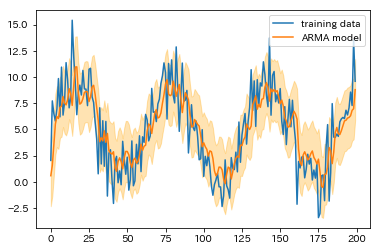

In [7]:
plt.plot(x_train, label='training data')
plt.plot(y_test, label='ARMA model')
plt.fill_between(np.arange(len(y_test)), y_test-std, y_test+std, alpha=0.3, color='orange')
plt.legend(loc='upper right')